In [5]:
'''
TRAINING
RUN THIS FIRST (change paths accordingly) - feel free to play around with # of test and training images
'''
import pandas as pd
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
np.random.seed(0) 

#CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

'''
Dataset has 28 images:
18 used for training/validation
10 for testing
'''
path1 = 'ChaseDB-1/training-images' #training images directory
path2 = 'ChaseDB-1/training-masks' #training masks directory

image_dataset = []
mask_dataset = [] 

patch_size = 512

# PRE PROCESS IMAGES

images = sorted(os.listdir(path1)) 
for i, image_name in enumerate(images):  
    if image_name.endswith(".jpg") or image_name.endswith(".JPG"):                   
        image = skimage.io.imread(path1+"/"+image_name)  #Read image
        image = image[:,:,1] #selecting green chfannel
        image = clahe_equalized(image) #applying CLAHE
        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
        image = Image.fromarray(image)        
        image = image.resize((SIZE_X, SIZE_Y)) #resize image       
        image = np.array(image) 
        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):                        
            single_patch_img = patches_img[i,j,:,:]                 
            single_patch_img = (single_patch_img.astype('float32')) / 255.                    
            image_dataset.append(single_patch_img)

masks = sorted(os.listdir(path2))  
for i, mask_name in enumerate(masks):  
    if mask_name.endswith(".jpg") or mask_name.endswith(".png"):                  
        mask = skimage.io.imread(path2+"/"+mask_name)   #Read masks
        #mask = mask[:,:,1] #selecting green channel
        #mask = clahe_equalized(mask) #applying CLAHE
        SIZE_X = (mask.shape[1]//patch_size)*patch_size #getting size multiple of patch size
        SIZE_Y = (mask.shape[0]//patch_size)*patch_size #getting size multiple of patch size
        mask = Image.fromarray(mask)        
        mask = mask.resize((SIZE_X, SIZE_Y))  #resize image
        mask = np.array(mask)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
            
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):                            
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask.astype('float32'))/255. 
                mask_dataset.append(single_patch_mask)

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

#importing models
from model import unetmodel, residualunet, attentionunet, residual_attentionunet
from tensorflow.keras.optimizers import Adam
from evaluation_metrics import IoU_coef,IoU_loss

IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

#model = load_model('retina_Unet_150epochs.hdf5')

#output_ = model.output

#get train test split
from sklearn.model_selection import train_test_split
val_size = 0.3  # 12 train, 6 validation
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=val_size, random_state=0)

from tensorflow.keras.models import load_model
# load pretrained model (need o pass IoU as custom objects as they are not predefined)
model = load_model('retina_Unet_150epochs.hdf5', custom_objects={'IoU_loss': IoU_loss, 'IoU_coef': IoU_coef})





NameError: name 'patches_img' is not defined

In [38]:
'''
TRANSFER LEARNING
- Pick number of layers to train
- For UNet, may not be as simple as picking the last x layers, but rather which layers to train
- E.g. only train output layer plus some upsampling layers, etc
'''

'''
# check model layer names
for layer in model.layers:
    print (layer.name)
'''

'''
# freeze all layers except last 7
to_train = 10 # # of layers to train
for layer in model.layers[:-to_train]:
    layer.trainable = False
'''

# initially freeze all layers
for layer in model.layers:
    layer.trainable = False

#  train output layer
for layer in model.layers[-1:]:
    layer.trainable = True

# train only upsampling layers
for layer in model.layers:
    if 'up_sampling2d' in layer.name:
        layer.trainable = True
        
# train only conv layers past the mid point
for layer in model.layers[40:]:
    if 'conv2d' in layer.name:
        layer.trainable = True


# check trainable layers
import pandas as pd
pd.set_option('display.max_rows', None)
layers = [(layer.name, layer.trainable) for layer in model.layers]
layer_df = pd.DataFrame(layers, columns=['Layer Name', 'Layer Trainable'])
#display(layer_df)
display(layer_df[layer_df['Layer Trainable']==True])


model.compile(optimizer = Adam(learning_rate= 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])    

# early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 32,
                    validation_data=(x_test, y_test), 
                    shuffle=False,
                    epochs=150, 
                    callbacks=[early_stop])


,Layer Name,Layer Trainable
40,up_sampling2d,True
42,conv2d_10,True
46,conv2d_11,True
49,up_sampling2d_1,True
51,conv2d_12,True
55,conv2d_13,True
58,up_sampling2d_2,True
60,conv2d_14,True
64,conv2d_15,True
67,up_sampling2d_3,True


Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: -0.5093 - accuracy: 0.9107 - IoU_coef: 0.5093 - val_loss: -0.5356 - val_accuracy: 0.9155 - val_IoU_coef: 0.5356
Epoch 2/150
1/1 [==============================] - 0s 349ms/step - loss: -0.5525 - accuracy: 0.9216 - IoU_coef: 0.5525 - val_loss: -0.5762 - val_accuracy: 0.9225 - val_IoU_coef: 0.5762
Epoch 3/150
1/1 [==============================] - 0s 350ms/step - loss: -0.5821 - accuracy: 0.9254 - IoU_coef: 0.5821 - val_loss: -0.6037 - val_accuracy: 0.9265 - val_IoU_coef: 0.6037
Epoch 4/150
1/1 [==============================] - 0s 352ms/step - loss: -0.5981 - accuracy: 0.9270 - IoU_coef: 0.5981 - val_loss: -0.6143 - val_accuracy: 0.9280 - val_IoU_coef: 0.6143
Epoch 5/150
1/1 [==============================] - 0s 352ms/step - loss: -0.6059 - accuracy: 0.9281 - IoU_coef: 0.6059 - val_loss: -0.6201 - val_accuracy: 0.9288 - val_IoU_coef: 0.6201
Epoch 6/150
1/1 [==============================] - 0s 351ms/step - loss: -0.61

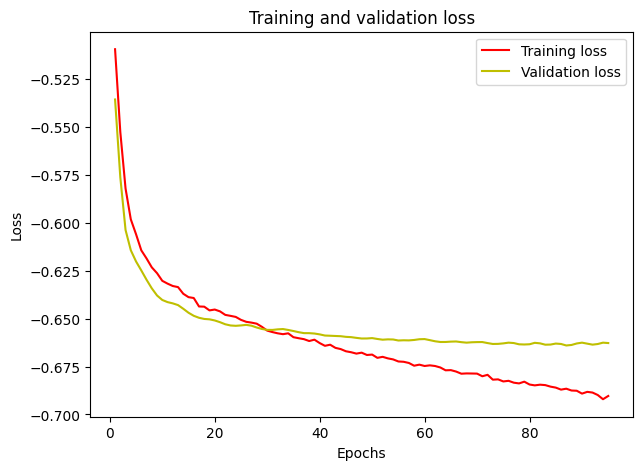

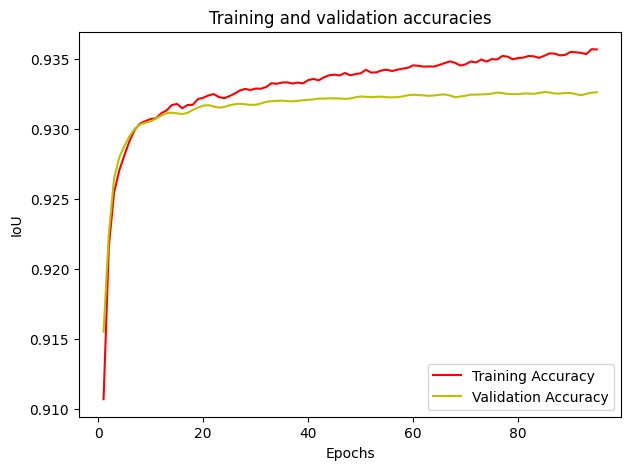

In [39]:
#PLOT LOSS AND ACCURACY
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training-validation accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()



In [44]:
'''
PREDICTIONS ON 10 TEST IMAGES
'''

from sklearn.metrics import jaccard_score,confusion_matrix
from patchify import patchify, unpatchify

from evaluation_metrics import IoU_coef, IoU_loss
from skimage import io, color


testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []

path1 = 'ChaseDB-1/test-images' #training images directory
path2 = 'ChaseDB-1/test-masks' #training masks directory

testimages = sorted(os.listdir(path1))
testmasks =  sorted(os.listdir(path2))

#model = load_model('retina_Unet_150epochs.hdf5', custom_objects={'IoU_loss': IoU_loss, 'IoU_coef': IoU_coef})

for idx, image_name in enumerate(testimages):  
    if image_name.endswith(".jpg"):  
        
        predicted_patches = []
        test_img = skimage.io.imread(path1+"/"+image_name)
     
    test = test_img[:,:,1] #selecting green channel
    test = clahe_equalized(test) #applying CLAHE
    SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
    SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
    test = cv2.resize(test, (SIZE_X, SIZE_Y))
    
    testimg.append(test)           
    test = np.array(test)
    

    patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch = patches[i,j,:,:]
            single_patch_norm = (single_patch.astype('float32')) / 255.
            single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
            single_patch_input = np.expand_dims(single_patch_norm, 0)
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
            predicted_patches.append(single_patch_prediction)
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
    reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img
    prediction.append(reconstructed_image) 
    

    groundtruth=[]
    groundtruth = skimage.io.imread(path2+'/'+testmasks[idx]) #reading mask of the test img
    if len(groundtruth.shape) == 3:
        groundtruth = groundtruth[:,:,-1]
    SIZE_X = (groundtruth.shape[1]//patch_size)*patch_size 
    SIZE_Y = (groundtruth.shape[0]//patch_size)*patch_size  
    groundtruth = cv2.resize(groundtruth, (SIZE_X, SIZE_Y))  
    
    ground_truth.append(groundtruth)
    
    y_true = groundtruth
    #print(y_true)
    y_pred = reconstructed_image
    
    labels = [0, 1]
    IoU = []
    
    jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), labels=labels, average='weighted')
    IoU.append(jaccard)
    IoU = np.mean(IoU) #jacard/IoU of single image
    global_IoU.append(IoU)

    cm=[]
    accuracy = []
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]) #accuracy of single image
    global_accuracy.append(accuracy)


avg_acc =  np.mean(global_accuracy)
mean_IoU = np.mean(global_IoU)

print('Average accuracy is',round(avg_acc*100,2))
print('mean IoU is',mean_IoU)


1/1 [==============================] - 0s 17ms/step
Average accuracy is 98.62
mean IoU is 0.8977729936842843


['Image_10L.jpg', 'Image_10R.jpg', 'Image_11L.jpg', 'Image_11R.jpg', 'Image_12L.jpg', 'Image_12R.jpg', 'Image_13L.jpg', 'Image_13R.jpg', 'Image_14L.jpg', 'Image_14R.jpg']


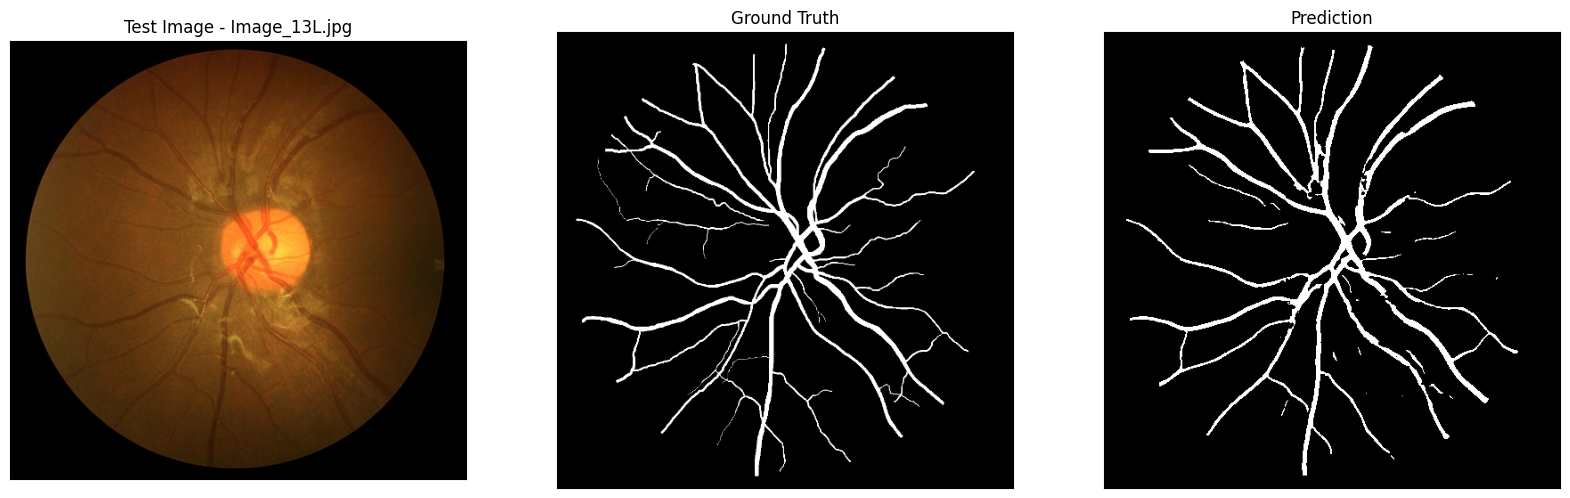

In [45]:
'''
RANDOM TEST IMAGE TO PREDICTION PLOT
'''


testimg_t = []
testimages_t = sorted(os.listdir(path1))
print(testimages_t)
for idx, image_name in enumerate(testimages_t):
    test_img = skimage.io.imread(path1+"/"+image_name)  
    testimg_t.append(test_img)
    
    
import random
test_img_number = random.randint(0, len(testimg_t)-1)
plt.figure(figsize=(20, 18))
plt.subplot(231)
plt.title(f'Test Image - {testimages_t[test_img_number]}')
plt.xticks([])
plt.yticks([])
plt.imshow(testimg_t[test_img_number])
plt.subplot(232)
plt.title('Ground Truth')
plt.xticks([])
plt.yticks([])
plt.imshow(ground_truth[test_img_number],cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(prediction[test_img_number],cmap='gray')

plt.show()